In [1]:
using JuMP, CPLEX
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
using Printf
using Plots

# Function to calculate Euclidean distance
function calculate_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)
    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i==j)
                distances[i,j] = 100
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 100
            else
                distances[i, j] = floor(calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    # Printing the matrix with formatting
    for i in 1:length(x)
        for j in 1:length(x)
            #@printf "%-5.2f  " distances[i, j]
        end
        #println()
    end
    
    return distances

end

# Function to generate A2
function generateA2(S,C)
    # Generate the set union of S and C
    unionSC = union(S, C)
    
    # Generate all combinations of (i, j) in 0 ∪ S with i != j
    A1 = Set([(i, j) for i in union(1,S), j in  union(1,S) if i != j])
    
    # Generate all combinations of (i, j) in S ∪ C with i != j
    all_combinations = Set([(i, j) for i in unionSC, j in unionSC if i != j])

    # Generate combinations of (i, j) where both i and j are in S
    combinations_in_S = Set([(i, j) for i in S, j in S if i != j])

    # Subtract the set of combinations_in_S from all_combinations
    A2 = setdiff(all_combinations, combinations_in_S)
    return A1,A2
        
end

function displayMap()
   # Create a scatter plot
    p = scatter(x_coor, y_coor,
                   title = "Coordinate Plot",
                   xlabel = "X-axis",
                   ylabel = "Y-axis",
                   legend = false)

    # Create a scatter plot
    p = scatter(x_coor[2:1+np], y_coor[2:1+np], 
            title = "Coordinate Plot",
            xlabel = "X-axis", ylabel = "Y-axis",
            legend = false)

    # Add the depot point in a different color
    scatter!([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow)
    # Add the customer point in a different color
    scatter!([x_coor[2+np:1+nc+np]], [y_coor[np+2:1+nc+np]], 
             markersize = 8, markercolor = :pink)
   
    # Add the initial parking place in a different color
    for p in P
        if PI[p-1]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :blue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 8, markercolor = :white)
        end
    end

    # Add annotations for each node
    for i in 1:length(x_coor)
        annotate!(x_coor[i], y_coor[i]+0.5, text(node_labels[i], :center, 8))
        if i<= nc
            annotate!(x_coor[i+1+np], y_coor[i+1+np]-0.5, text(demand_labels[i], :center, 8)) 
        end
    end 
end

displayMap (generic function with 1 method)

In [4]:
# Number of customers
nc = 3
# Coordinate x (Depot then parking places then customers)
x_coor = [4,0,8,4,0,4,-1,10,3]
# Coordinate y (Depot then parking places then customers)
y_coor = [4,8,8,0,2,10,8,10,0]
# Number of parking places
np = length(x_coor)-1-nc
P = 2 : np+1 #Set of parking place
C = np+2 : np+nc+1 #Set of customers
A1 = 1 : 1+np
A2 = 2 : 1+np+nc
V1 = 1:1 #Set of FEV
V2 = 1:1 #Set of SEV
N = 1:np+nc+1
Q0 = 50
Q1 = 100
Q2 = 20
D = [15,20,10]
M = 10000
PI = [1,1,1,0,0]

5-element Vector{Int64}:
 1
 1
 1
 0
 0

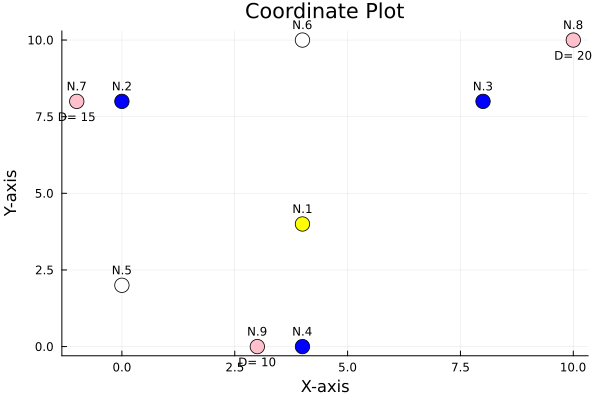

In [5]:
node_labels = [string("N.", i) for i in 1:length(x_coor)]
demand_labels = [string("D= ", D[i-1-np]) for i in 2+np:length(x_coor)]
# Disatance matrix
distances = calculate_distance_matrix(x_coor,y_coor,nc)

displayMap()
plot!()

In [6]:
model=Model(CPLEX.Optimizer)

# Decision variable
@variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
@variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
for i in 1:np+1
    @constraint(model, x[i, i] == 0)
    @constraint(model, y[i, i] == 0)
end

@variable(model, t[A1]>=0, Int) #Arrival time

@variable(model, w[P]>=0) #Amount of freight transported from the depot to parking node

@variable(model, z[A2,A2], Bin)#Arc(x,y) traversed by SEV dispatched from p
for i in A2
    @constraint(model, z[i,i] == 0)
end

@variable(model, f[A2,A2]>=0) #Load of SEV

@objective(model, Min,
    sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * z[i, j] for i in A2, j in A2 if i != j))

#1 #2
#Flow conservation at parking for FEV
@constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j)==sum(x[i,j] for j in A1 if i != j))
@constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j)<=1)

# #4
#Limit for mobile microhub
@constraint(model, [i in A1, j in A1], y[i,j]<=x[i,j])

#5 #6
#Flow conservation at depot
@constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
@constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)

#7
#Capacity limit for FEV
@constraint(model, sum(w[p] for p in P)<=Q0)

#11
#Link 1st and 2nd
@constraint(model, [p in P], w[p]== sum(f[p,j] for j in A2 if p !=j))

#12
#Capacity limit for MM
@constraint(model, [p in P], w[p]<=Q1*sum(x[i,p] for i in A1))

# #13 #14
#Flow consercvation at parking and customerfor SEV
@constraint(model, [i in A2], sum(z[i,j] for j in A2)==sum(z[j,i] for j in A2))
@constraint(model, [p in P], sum(z[p,j] for j in A2)<=1)
@constraint(model, [i in C], sum(z[i,j] for j in A2) ==1)


#17
#Customer demand met
@constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2)==D[i-1-np])
#*
@constraint(model, [i in A2, j in A2], f[i,j]<=10000*z[i,j])
#21
#Time constraint
@constraint(model, [i in P, j in P], t[i]-t[j]+(1+np)*x[i,j]<=np)

#24
#Max travel distance for FEV
@constraint(model, [i in A2, j in A2, i != j], z[i,j]*distances[i,j]<=5)

JuMP.Containers.SparseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}, 3, Tuple{Int64, Int64, Bool}} with 64 entries:
  [2, 2, false]  =  100 z[2,2] ≤ 5
  [2, 3, true ]  =  8 z[2,3] ≤ 5
  [2, 4, true ]  =  8 z[2,4] ≤ 5
  [2, 5, true ]  =  6 z[2,5] ≤ 5
  [2, 6, true ]  =  4 z[2,6] ≤ 5
  [2, 7, true ]  =  z[2,7] ≤ 5
  [2, 8, true ]  =  10 z[2,8] ≤ 5
  [9, 2, true ]  =  8 z[9,2] ≤ 5
                 ⋮
  [9, 3, true ]  =  9 z[9,3] ≤ 5
  [9, 4, true ]  =  z[9,4] ≤ 5
  [9, 5, true ]  =  3 z[9,5] ≤ 5
  [9, 6, true ]  =  10 z[9,6] ≤ 5
  [9, 7, true ]  =  8 z[9,7] ≤ 5
  [9, 8, true ]  =  12 z[9,8] ≤ 5
  [9, 9, false]  =  100 z[9,9] ≤ 5

In [7]:
# Solve the model
optimize!(model)

# Check solution status and display results
if termination_status(model) == MOI.OPTIMAL
    println("Total distance traveled: ", objective_value(model))
    for i in A1
        for j in A1
            if value(x[i,j])==1
                print("  x[",i,",",j,"]=",value(x[i,j]))
            end
        end
    end
    println(" ")
    for i in A1 print("  t[",i,"]=",value(t[i])) end
    println(" ")
    for i in A2
        for j in A2
            if value(z[i,j])==1
                print("  z[",i,",",j,"]=",value(z[i,j]))
            end
        end
    end
    println(" ")
    for i in P
        print("  w[",i,"]=",value(w[i]))
    end
    println(" ")
    for i in A2
        for j in A2
            if value(f[i,j]) != 0
                print("  f[",i,",",j,"]=",value(f[i,j]))
            end
        end
    end
else
    println("No feasible solution found.")
end

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
Tried aggregator 3 times.
MIP Presolve eliminated 189 rows and 152 columns.
MIP Presolve modified 82 coefficients.
Aggregator did 9 substitutions.
Reduced MIP has 53 rows, 50 columns, and 218 nonzeros.
Reduced MIP has 37 binaries, 5 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.42 ticks)
Probing fixed 0 vars, tightened 8 bounds.
Probing changed sense of 1 constraints.
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
MIP Presolve modified 38 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 51 rows, 49 columns, and 208 nonzeros.
Reduced MIP has 36 binaries, 5 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.20 ticks)
Probing fixed 0 vars, tightened 2 bounds.
Probing time = 0.00 sec. (0.04 ticks)
Clique table members: 24.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.

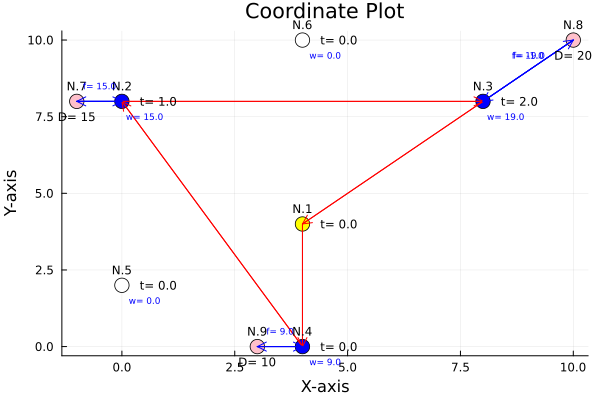

In [8]:
displayMap()
time_labels = [string("t= ", value(t[i])) for i in A1]
flow_labels = [string("f= ", floor(value(f[i,j]))) for i in A2 for j in A2]
loan_labels = [string("w= ", floor(value(w[i]))) for i in P]

# Add arcs between the locations if they are traversed
for i in A1
    annotate!(x_coor[i]+0.8, y_coor[i], text(time_labels[i], :center, 8))
    for j in A1         
        if value(x[i, j]) == 1
            plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                  line=:arrow,color = :red, label = "")
        end
    end
end

for i in A2
    for j in A2
        if value(z[i, j]) == 1
            plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
              line=:arrow,color = :blue, label = "")
            if value(f[i,j]) != 0
                mid_x = (x_coor[i] + x_coor[j]) / 2
                mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.5
                annotate!(mid_x, mid_y, text(flow_labels[(i-2)*(np+nc)+j-1],6 ,:blue))
            end
        end
    end
end

for p in P
    annotate!(x_coor[p]+0.5,y_coor[p]-0.5, text(loan_labels[p-1],6 ,:blue))
end

plot!()